In [1]:
import glob
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.feature_extraction import stop_words
import math
import re
import string
import nltk
from nltk import tokenize, sent_tokenize

print("Packages imported")

C:\Users\jacob\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


Packages imported


# Exploratory Data Analysis

# 1.1 Get Data

In [59]:
# Done in command line

# 1.2 Load Data

In [69]:
ndf = pd.DataFrame(columns=["filename",'text'])
path = "C:\\Users\\jacob\\OneDrive\\Desktop\\GitHub\\Deep-Learning-for-NLP-and-Speech-Recognition\\data"


for datafile in glob.glob(path + "/slate/*/*.txt"):
    f=open(datafile,"r",encoding="utf-8")
    ndf = ndf.append( {'filename':datafile,'text':f.read()} ,ignore_index=True)
    f.close()

ndf.count()

filename    4531
text        4531
dtype: int64

In [71]:
nltk.download('punkt')

df = pd.DataFrame()
for f in ndf['text']:
    sentence = sent_tokenize(f)
    df = df.append(sentence)
df.columns = ['text']
df.count()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jacob\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


text    214225
dtype: int64

# 1.3 PreProcessing

need to remove punctuation, hidden characters, and uppercase

In [74]:
def process_text(text):
    
    text = re.sub(r"\\n", " ", text)
    text = re.sub(r"\n", " ", text)
    
#     Remove punctuation
    text = text.translate(string.punctuation)
    
#     Convert words to lower case and split them
    text = text.lower().split()
    
    text = " ".join(text)
    #Clean text up
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    return text

# apply cleaning function to df['text']
df['text'] = df['text'].map(lambda x: process_text(x))

corpus = df['text'].tolist()
df.head()

,text
0,harmonic convergences you are right maxim stro...
1,it a sendup of the old model but in a differen...
2,with its belligerent grossness and misogyny hu...
3,it came right out with the anger that the regu...
4,maxim pokes fun at its progenitors but with co...


calculate basic stats such as document & sentence length

array([[<AxesSubplot:title={'center':'document length'}>]], dtype=object)

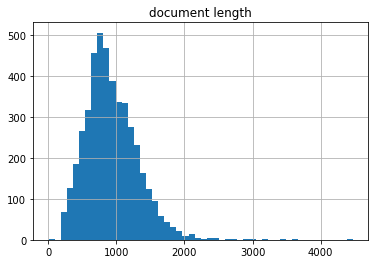

In [77]:
#document length histogram

pd.DataFrame([len(x.split()) for x in ndf['text']], columns=['document length']).hist(bins=50)

array([[<AxesSubplot:title={'center':'sentence length'}>]], dtype=object)

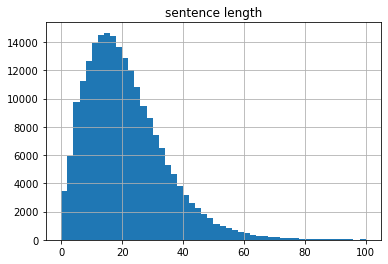

In [81]:
pd.DataFrame([len(x.split()) for x in df['text']], columns = ['sentence length']).hist(bins=50, range=(0,100))

examine other useful metrics such as top 1000 terms. 

words = [tokenize.word_tokenize(x) for x in corpus]
words = [y for x in words for y in x]

word_freq = pd.DataFrame(nltk.FreqDist(words).most_common(1000), columns = ['word', 'frequency'])
print(word_freq)


<AxesSubplot:>

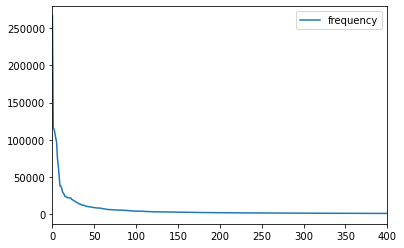

In [83]:
word_freq.plot(xlim=(0,400))

# 2 Learning Word Embeddings


skip gram model with negative sampling, followed by a GloVe model. But first, how many unique words exist in the corpus?

## 2.1 Create Dictionary of Vocabulary 

In [85]:
# Tokenize and create dictionary

class VocabWord:
    def __init__(self, word):
        self.word = word
        self.count = 0

vocab_items = []
vocab_hash = {}
word_count = 0

for token in ['<bol>', '<eol>']:
    vocab_hash[token] = len(vocab_items)
    vocab_items.append(VocabWord(token))
    
for line in df['text']:
    tokens = line.split()
    for token in tokens:
        if token not in vocab_hash:
            vocab_hash[token] = len(vocab_items)
            vocab_items.append(VocabWord(token))
            
        vocab_items[vocab_hash[token]].count +=1
        word_count += 1
        
        if word_count %1000000 == 0:
            print("\rReading word %d" % word_count)
            
    
    vocab_items[vocab_hash['<bol>']].count += 1
    vocab_items[vocab_hash['<eol>']].count += 1
    word_count += 2
    
print('Total words in training file: %d' % word_count)
print('Vocab Size: %d' % len(vocab_items))

Reading word 2000000
Reading word 3000000
Reading word 4000000
Total words in training file: 4860294
Vocab Size: 77440


## 2.2 Word2Vec

dim = dimension of word vectors
win = context window size(number of tokens)
start_alpha = starting learning rate
neg = number of samples for negative sampling
min_count = minimum number of mentions for a word to be included in vocabulary

In [86]:
# intialize parameters

dim = 100
win = 10
start_alpha = 0.05
neg = 10
min_count = 5

## 2.3 Handling Rare Words 

map vocabulary that is below the min_count threshold to out-of-vocabulary token

In [88]:
truncated = []
truncated.append(VocabWord('<unk>'))
unk_hash = 0

count_unk = 0
for token in vocab_items:
    if token.count < min_count:
        count_unk += 1
        truncated[unk_hash].count += token.count
    else:
        truncated.append(token)
        
truncated.sort(key = lambda token: token.count, reverse = True)

vocab_hash = {}

for i, token in enumerate(truncated):
    vocab_hash[token.word] = i
    
vocab_items = truncated
vocab_hash = vocab_hash
vocab_size = len(vocab_items)
print('Unknown vocab size:', count_unk)
print('Truncated vocab size: %d' % vocab_size )

Unknown vocab size: 45842
Truncated vocab size: 31599



# 2.4 Negative Sampling

create a negative sampling lookup table to use during training

In [89]:
# create a table of probabilities

power = 0.75
norm = sum([math.pow(t.count, power) for t in vocab_items])

table_size = int(1e8)
table = np.zeros(table_size, dtype=np.int)

p = 0
i = 0

for j, unigram in enumerate(vocab_items):
    p += float(math.pow(unigram.count, power))/norm
    while i < table_size and float(i)/ table_size < p:
        table[i] = j
        i += 1

def sample(table, count):
    indices = np.random.randint(low = 0, high=len(table), size = count)
    return [ table[i] for i in indices]

# 2.5 Training the Model

In [91]:
import struct

def sigmoid(z):
    if z > 6:
        return 1.0
    elif z < -6:
        return 0.0
    else:
        return 1 / (1 + math.exp(-z))
    
tmp = np.random.uniform(low = -0.5/dim, high=0.5/dim, size = (vocab_size, dim))
syn0 = np.ctypeslib.as_ctypes(tmp)
syn0 = np.array(syn0)

tmp = np.zeros(shape=(vocab_size, dim))
syn1 = np.ctypeslib.as_ctypes(tmp)
syn1 = np.array(syn1)

current_sent = 0
truncated_vocabulary = [x.word for x in vocab_items]
corpus = df['text'].tolist()

while current_sent < df.count()[0]:
#     line 
    line = corpus[current_sent]
#     current sentence, if the token is found within the truncated vocabulary list
#     then accept the token, else map it to the unknown token, and do this for every token 
#     from the begining of the line to the end of teh line(sentence)
    sent = [vocab_hash[token] if token in truncated_vocabulary else vocab_hash['<unk>']
           for token in [['<bol>'] + line.split() + ['<eol>']]]
    
#     for every sentence position at every token in the sentence
    for sent_pos, token in enumerate(sent):
        
#         randomly set the size of the current window
        current_win = np.random.randint(low=1, high=win+1)
#     must subtract so that the start of the context window is the left most context posistion
        context_start = max(sent_pos - current_win, 0)
#     must add so that the end of the context window is the right most context position
        context_end = min(sent_pos + current_win + 1, len(sent))
#     also necessary to skip over the current sentence position as this is a skip-gram model
        context = sent[context_start:sent_pos] + sent[sent_pos+1:context_end]
        
        
#         for every context word within the context window
        for context_word in context:
#         embed the word
            embed = np.zeros(DIM)
            classifiers = [(token, 1) + target[(target, 0)] for target in table.sample(neg)]
            
            for target, label in classifiers:
                
                z = np.dot(syn0[context_word], syn1[target])
                #activation function
                p = sigmoid(z)
                g = alpha * (label - p)
                embed += g * syn1[target]
                syn1[target] += g * syn0[context_word]
            syn0[context_word] += embed
            
        word_count += 1
    current_sent += 1
    if current_sent %2000 == 0:
        print('\rReading sentence %d' % current_sent)
        
embedding = dict(zip(truncated_vocabulary, syn0))
print('Trained embeddings')

# Save embeddings

fo = open("word2vec", 'w+')
for token, vector in zip(truncated_vocabulary, syn0):
    fo.write('%s' % token)
    for s in vector:
        fo.write(('%f' % s))
    fo.write('\n')
fo.close()

print(syn0.shape)

Reading sentence 2000
Reading sentence 4000
Reading sentence 6000
Reading sentence 8000
Reading sentence 10000
Reading sentence 12000
Reading sentence 14000
Reading sentence 16000
Reading sentence 18000
Reading sentence 20000
Reading sentence 22000
Reading sentence 24000
Reading sentence 26000
Reading sentence 28000
Reading sentence 30000
Reading sentence 32000
Reading sentence 34000
Reading sentence 36000
Reading sentence 38000
Reading sentence 40000
Reading sentence 42000
Reading sentence 44000
Reading sentence 46000
Reading sentence 48000
Reading sentence 50000
Reading sentence 52000
Reading sentence 54000
Reading sentence 56000
Reading sentence 58000
Reading sentence 60000
Reading sentence 62000
Reading sentence 64000
Reading sentence 66000
Reading sentence 68000
Reading sentence 70000
Reading sentence 72000
Reading sentence 74000
Reading sentence 76000
Reading sentence 78000
Reading sentence 80000
Reading sentence 82000
Reading sentence 84000
Reading sentence 86000
Reading sentenc